In [1]:
install.packages("dplyr");
library(dplyr);

Installing package into ‘/home/mati/R/x86_64-pc-linux-gnu-library/3.4’
(as ‘lib’ is unspecified)


Attaching package: ‘dplyr’


The following objects are masked from ‘package:stats’:

    filter, lag


The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union




In [2]:
df <- read.csv('data/winemag-data-130k-v2.csv', header = TRUE)

In [3]:
colnames(df)

[1] "X"                     "country"               "description"          
 [4] "designation"           "points"                "price"                
 [7] "province"              "region_1"              "region_2"             
[10] "taster_name"           "taster_twitter_handle" "title"                
[13] "variety"               "winery"

In [4]:
head(df)

,X,country,description,designation,points,price,province,region_1,region_2,taster_name,taster_twitter_handle,title,variety,winery
,<int>,<fct>,<fct>,<fct>,<int>,<dbl>,<fct>,<fct>,<fct>,<fct>,<fct>,<fct>,<fct>,<fct>
1,0,Italy,"Aromas include tropical fruit, broom, brimstone and dried herb. The palate isn't overly expressive, offering unripened apple, citrus and dried sage alongside brisk acidity.",Vulkà Bianco,87,NA,Sicily & Sardinia,Etna,,Kerin O’Keefe,@kerinokeefe,Nicosia 2013 Vulkà Bianco (Etna),White Blend,Nicosia
2,1,Portugal,"This is ripe and fruity, a wine that is smooth while still structured. Firm tannins are filled out with juicy red berry fruits and freshened with acidity. It's already drinkable, although it will certainly be better from 2016.",Avidagos,87,15,Douro,,,Roger Voss,@vossroger,Quinta dos Avidagos 2011 Avidagos Red (Douro),Portuguese Red,Quinta dos Avidagos
3,2,US,"Tart and snappy, the flavors of lime flesh and rind dominate. Some green pineapple pokes through, with crisp acidity underscoring the flavors. The wine was all stainless-steel fermented.",,87,14,Oregon,Willamette Valley,Willamette Valley,Paul Gregutt,@paulgwine,Rainstorm 2013 Pinot Gris (Willamette Valley),Pinot Gris,Rainstorm
4,3,US,"Pineapple rind, lemon pith and orange blossom start off the aromas. The palate is a bit more opulent, with notes of honey-drizzled guava and mango giving way to a slightly astringent, semidry finish.",Reserve Late Harvest,87,13,Michigan,Lake Michigan Shore,,Alexander Peartree,,St. Julian 2013 Reserve Late Harvest Riesling (Lake Michigan Shore),Riesling,St. Julian
5,4,US,"Much like the regular bottling from 2012, this comes across as rather rough and tannic, with rustic, earthy, herbal characteristics. Nonetheless, if you think of it as a pleasantly unfussy country wine, it's a good companion to a hearty winter stew.",Vintner's Reserve Wild Child Block,87,65,Oregon,Willamette Valley,Willamette Valley,Paul Gregutt,@paulgwine,Sweet Cheeks 2012 Vintner's Reserve Wild Child Block Pinot Noir (Willamette Valley),Pinot Noir,Sweet Cheeks
6,5,Spain,"Blackberry and raspberry aromas show a typical Navarran whiff of green herbs and, in this case, horseradish. In the mouth, this is fairly full bodied, with tomatoey acidity. Spicy, herbal flavors complement dark plum fruit, while the finish is fresh but grabby.",Ars In Vitro,87,15,Northern Spain,Navarra,,Michael Schachner,@wineschach,Tandem 2011 Ars In Vitro Tempranillo-Merlot (Navarra),Tempranillo-Merlot,Tandem


## Price vs Points

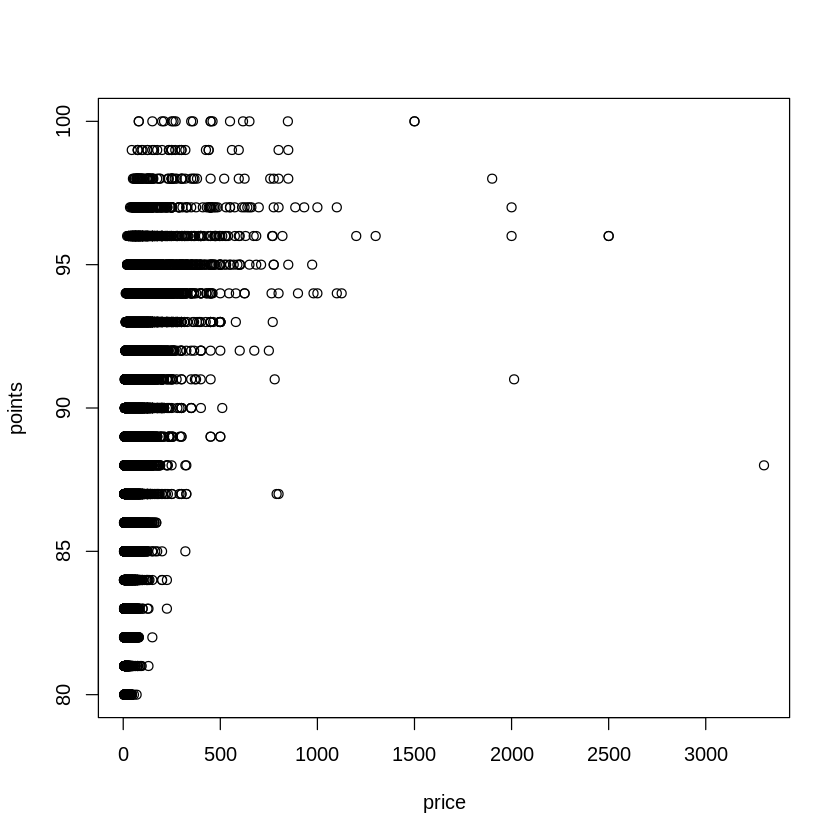

In [5]:
plot(x=df$price, xlab='price', y=df$points, ylab='points')

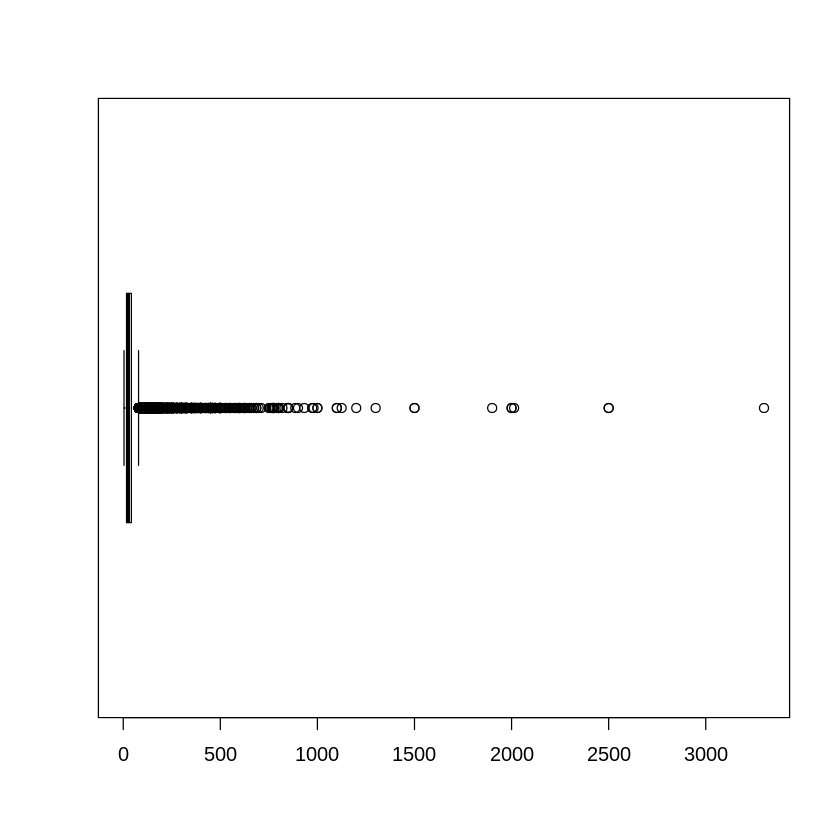

In [6]:
boxplot(df$price, horizontal=TRUE)

In [7]:
remove_outliers <- function(df, col) {
  df[!df[[col]] %in% boxplot.stats(df[[col]])$out, ]
}

In [8]:
remove_missing <- function(df) {
    df[complete.cases(df), ]
}

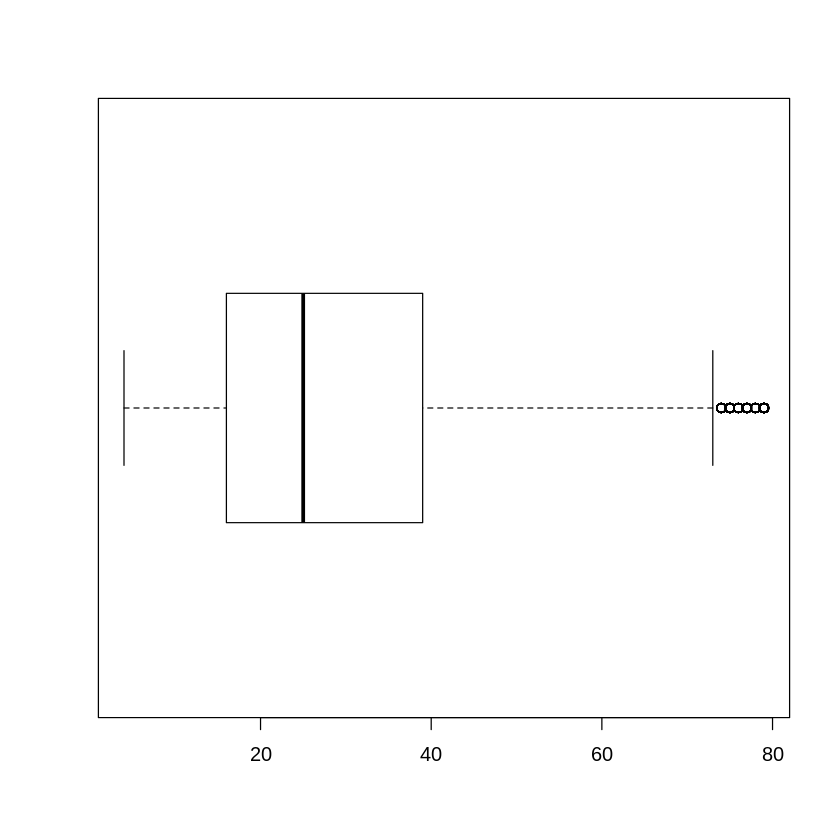

In [9]:
boxplot(remove_outliers(df, 'price')$price, horizontal=TRUE)

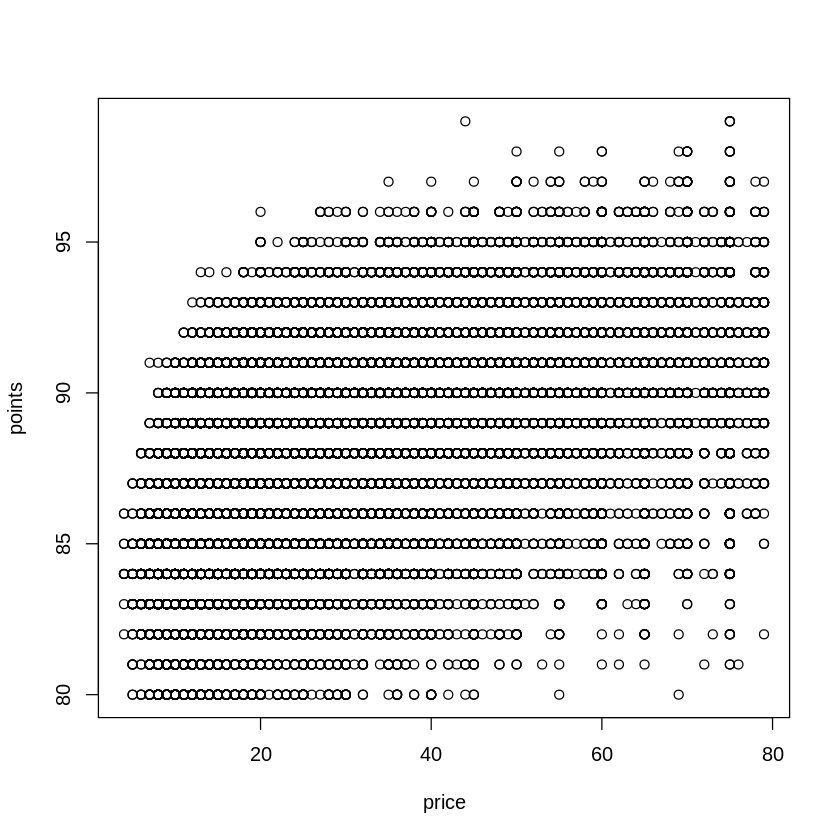

In [10]:
price_qnt = remove_outliers(df, 'price')
plot(x=price_qnt$price, xlab='price', y=price_qnt$points, ylab='points')

## Points

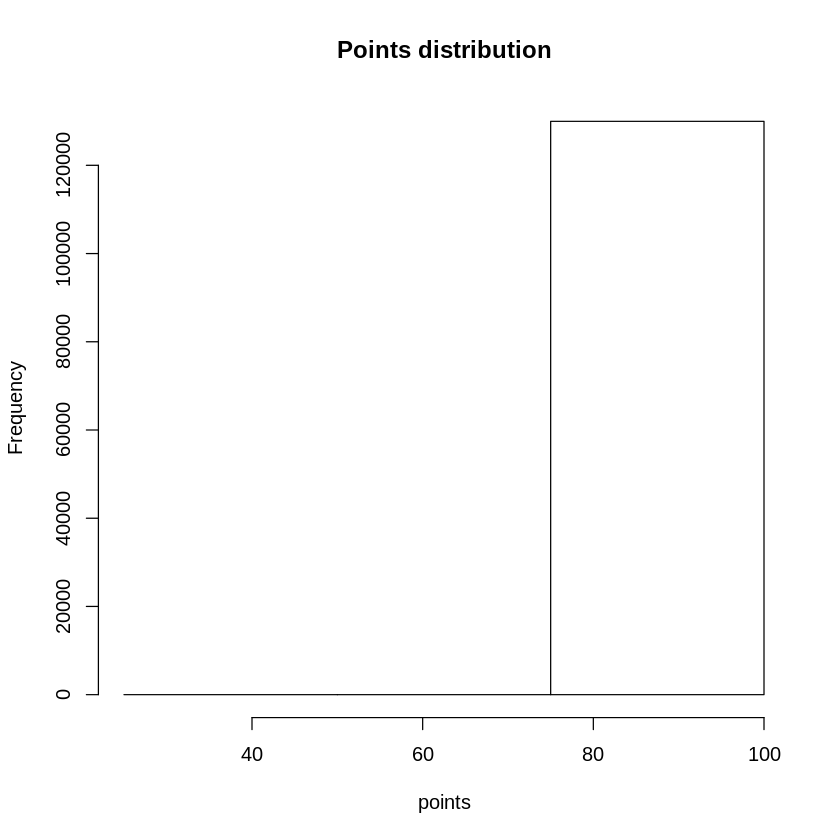

In [11]:
hist(df$points, breaks=c(25, 50, 75, 100), xlab='points', main='Points distribution')

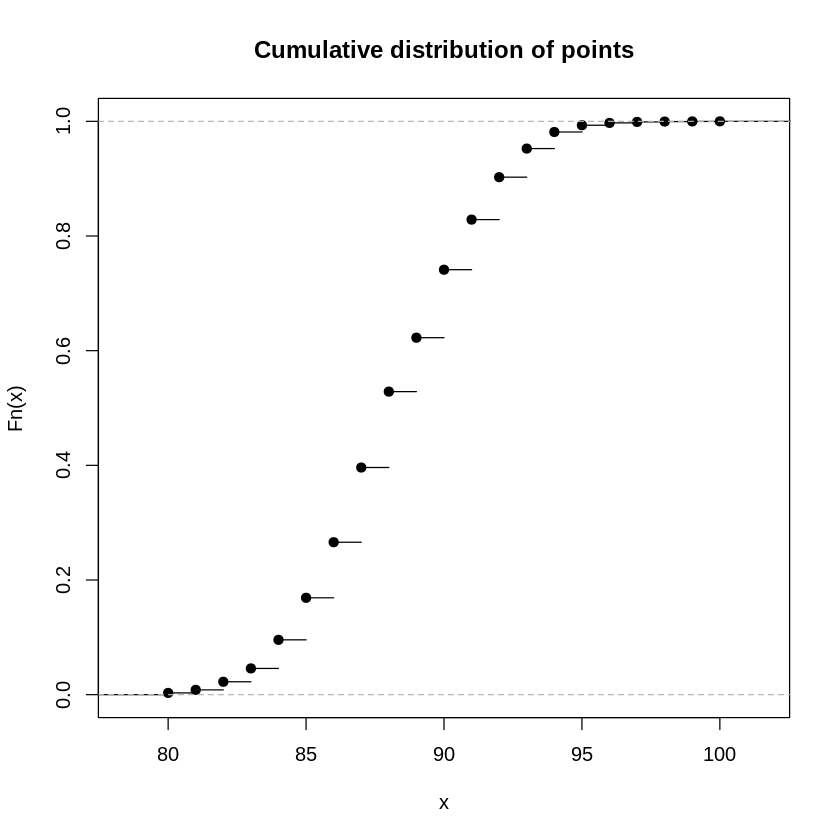

In [12]:
plot(ecdf(df$points), main='Cumulative distribution of points')

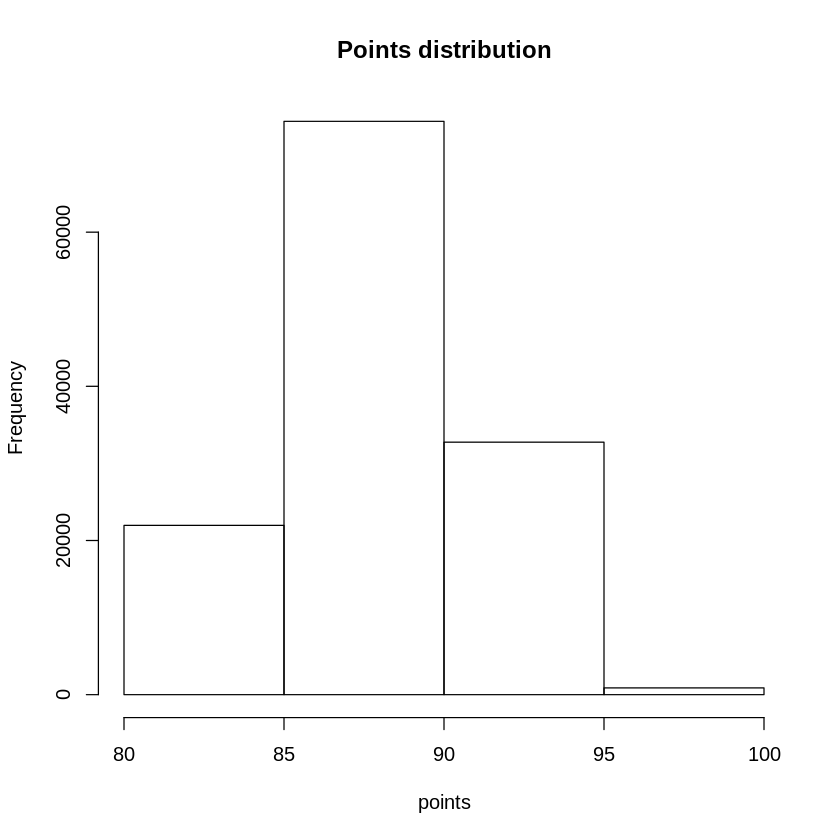

In [13]:
hist(df$points, breaks=4, xlab='points', main='Points distribution')

There is overrepresentation of medium-graded wines. In order to flatten the distribution we will need to use oversampling/undersampling methods.

## Descriptions' common words

### Clean

In [14]:
install.packages('SnowballC')
install.packages('tidytext')
install.packages('dplyr')
library(SnowballC)
library(tidytext)
library(dplyr)

Installing package into ‘/home/mati/R/x86_64-pc-linux-gnu-library/3.4’
(as ‘lib’ is unspecified)

Installing package into ‘/home/mati/R/x86_64-pc-linux-gnu-library/3.4’
(as ‘lib’ is unspecified)

Installing package into ‘/home/mati/R/x86_64-pc-linux-gnu-library/3.4’
(as ‘lib’ is unspecified)



In [15]:
data('stop_words')

In [17]:
descr <- df$description
descr <- gsub('@\\w+', '', descr)
descr <- gsub('https?://.+', '', descr)
descr <- gsub('\\d+\\w*\\d*', '', descr)
descr <- gsub('#\\w+', '', descr)
descr <- gsub('[^\x01-\x7F]', '', descr)
descr <- gsub('[[:punct:]]', ' ', descr)
descr <- gsub('\n', ' ', descr)
descr <- gsub('^\\s+', '', descr)
descr <- gsub('\\s+$', '', descr)
descr <- gsub('[ |\t]+', ' ', descr)
df['text'] <- descr

In [18]:
text_data <- mutate(df, text = as.character(text)) %>% 
    select(text) %>% 
    unnest_tokens("word", text)

In [19]:
head(text_data  %>% count(word) %>% arrange(desc(n)), 10)

,word,n
,<chr>,<int>
1,and,347732
2,the,221199
3,a,179558
4,of,173037
5,with,120424
6,this,114036
7,is,96720
8,it,85778
9,wine,80179


In [ ]:
tidied_text_data <- text_data %>% anti_join(stop_words)

Joining, by = "word"



In [ ]:
tidied_text_data <- tidied_text_data %>% mutate_at('word', funs(wordStem((.), language='en')))

In [ ]:
head(tidied_text_data %>% count(word) %>% arrange(desc(n)), 10)